#  SECTION A: PROJECT HEADER + BUSINESS BRIEFING

**Project:** Mobile Transaction Fraud Analysis  
**Analyst:** Gana Joshua Danlami  
**Company (Hypothetical):** PaySim Finance  
**Duration:** June 2025  
**Data Source:** [PaySim Kaggle Dataset](https://www.kaggle.com/datasets/ealaxi/paysim1)  
**Tools:** Python, Pandas, Seaborn, Matplotlib, Google Colab

---

###  PROJECT OVERVIEW

PaySim Finance is facing growing financial losses due to fraudulent transactions.  
As the lead data analyst, my goal is to identify fraud patterns, transaction types most affected, and recommend strategies for early detection.  
i’ll analyze over 1 million transaction records, generate visuals, and summarize business insights for the management team.

###  KEY QUESTIONS TO ANSWER
- What types of transactions are most targeted by fraudsters?  
- Are there account behavior patterns linked to fraud?  
- Can we spot red flags that indicate suspicious activity early?

Let’s dive in 👇


In [2]:
# Step 1: Load Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style='whitegrid')


In [3]:
# Step 2: Mount Google Drive and Load Dataset
from google.colab import drive
drive.mount('/content/drive')

# Replace this path with the actual full path to your CSV inside your Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/PS_20174392719_1491204439457_log.csv'

# Step 3: Load the data
df = pd.read_csv(file_path)

# Preview data
df.head()


Mounted at /content/drive


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


# Section C: Dataset Exploration & Sanity Checks

In [4]:
# Check number of rows ad columns
print("Dataset shape:", df.shape)

# Check column names and data types
print("\nColumn Info:")
print(df.dtypes)

# Check for missing/null values
print("\nMissing Values:")
print(df.isnull().sum())

# View sample records
print("\nSample Rows:")
print(df.sample(5))


Dataset shape: (6362620, 11)

Column Info:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Sample Rows:
         step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
4490122   324   CASH_IN 113814.45  C2090897648       17443.00       131257.45   
4919440   350  CASH_OUT 226529.92   C279334440       21401.00            0.00   
5087485   355   PAYMENT  21040.86   C887726678           0.00            0.00   
2186066   185   CASH_IN  33365.69   C364591239    10463910.14     104

# Section D: Feature Breakdown + Label Exploration

In [5]:
# SECTION D: Feature Brekdown + Label Explortion

# 1. Transaction Types: What kind of operations exist?
print("Transaction Types:\n", df['type'].value_counts(), "\n")

# 2. Fraud vs Non-Fraud: How imbalanced is the target variable?
print("Fraud Distribution:\n", df['isFraud'].value_counts(normalize=True) * 100, "\n")

# 3. Flagged vs Not Flagged by the System
print("Flagged Transactions:\n", df['isFlaggedFraud'].value_counts(), "\n")

# 4. Unique senders & receivers
print("Unique Senders:", df['nameOrig'].nunique())
print("Unique Receivers:", df['nameDest'].nunique(), "\n")

# 5. Any transaction types associated with fraud?
fraud_by_type = df[df['isFraud'] == 1]['type'].value_counts()
print("Fraudulent Transaction Types:\n", fraud_by_type, "\n")

# 6. Add balance deltas to see actual fund movement (will help with logic checks later)
df['deltaOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Quick preview of new columns
print("New Columns Preview:\n", df[['deltaOrig', 'deltaDest']].head())


Transaction Types:
 type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64 

Fraud Distribution:
 isFraud
0   99.87
1    0.13
Name: proportion, dtype: float64 

Flagged Transactions:
 isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64 

Unique Senders: 6353307
Unique Receivers: 2722362 

Fraudulent Transaction Types:
 type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64 

New Columns Preview:
    deltaOrig  deltaDest
0    9839.64       0.00
1    1864.28       0.00
2     181.00       0.00
3     181.00  -21182.00
4   11668.14       0.00


# SECTION E: Fraud Logic Check
### Goal:
Understand behavioral patterns in fraudulent vs. normal transactions, focusing on CASH_OUT and TRANSFER.

# STEP 1: Filter Fraud Transactions

In [6]:
# Filter out only fraudulent transactions
fraud_df = df[df['isFraud'] == 1]

# Focus on just 'TRANSFER' and 'CASH_OUT'
fraud_types = fraud_df['type'].value_counts()
print("Fraud by Type:\n", fraud_types)

# Check what % of all frauds they represent
fraud_type_pct = fraud_df['type'].value_counts(normalize=True) * 100
print("\n% of Fraudulent Transactions by Type:\n", fraud_type_pct)


Fraud by Type:
 type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

% of Fraudulent Transactions by Type:
 type
CASH_OUT   50.12
TRANSFER   49.88
Name: proportion, dtype: float64


# STEP 2: Fraudulent Behavior Patterns

In [7]:
# Check if origin accounts had zero balance before sending money
zero_origin_frauds = fraud_df[fraud_df['oldbalanceOrg'] == 0]
print("Fraudulent transactions with 0 balance at origin:", len(zero_origin_frauds))

# Check if destination balance did NOT change after receiving funds
no_change_dest = fraud_df[fraud_df['oldbalanceDest'] == fraud_df['newbalanceDest']]
print("Fraud transactions where destination balance didn't change:", len(no_change_dest))

# Sample suspicious fraud rows
fraud_df[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].sample(5)


Fraudulent transactions with 0 balance at origin: 41
Fraud transactions where destination balance didn't change: 4086


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
1030293,TRANSFER,931684.75,931684.75,0.00,0.00,0.00
1383995,TRANSFER,303432.45,303432.45,0.00,0.00,0.00
1060033,TRANSFER,1082718.08,1082718.08,0.00,0.00,0.00
3193225,TRANSFER,18035.14,18035.14,0.00,0.00,0.00
1069130,TRANSFER,2142164.00,2142164.00,0.00,0.00,0.00


# STEP 3: Compare With Normal Transactions

In [8]:
# Filter non-fraud transactions of same types
non_fraud_df = df[(df['isFraud'] == 0) & (df['type'].isin(['TRANSFER', 'CASH_OUT']))]

# Sample comparisons
print("Avg origin balance (non-fraud):", non_fraud_df['oldbalanceOrg'].mean())
print("Avg origin balance (fraud):", fraud_df['oldbalanceOrg'].mean())

print("Avg destination change (non-fraud):", (non_fraud_df['newbalanceDest'] - non_fraud_df['oldbalanceDest']).mean())
print("Avg destination change (fraud):", (fraud_df['newbalanceDest'] - fraud_df['oldbalanceDest']).mean())


Avg origin balance (non-fraud): 42879.68556281309
Avg origin balance (fraud): 1649667.6057116764
Avg destination change (non-fraud): 345025.8215224808
Avg destination change (fraud): 735457.9980713503


# STEP 4: Quick Visualization

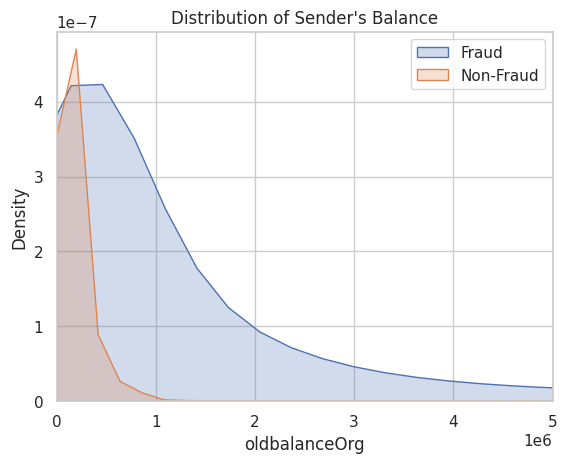

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare origin balance between fraud and non-fraud
sns.kdeplot(data=fraud_df, x='oldbalanceOrg', label='Fraud', fill=True)
sns.kdeplot(data=non_fraud_df, x='oldbalanceOrg', label='Non-Fraud', fill=True)
plt.title("Distribution of Sender's Balance")
plt.legend()
plt.xlim(0, 5000000)  # Limit x for better view
plt.show()


##  Feature Engineering Plan

###  Feature Set 1: Transaction Behavior
- `isHighRiskType`: 1 if transaction type is `TRANSFER` or `CASH_OUT`, else 0
- `isOrigEmptied`: 1 if `oldbalanceOrg == amount` and `newbalanceOrig == 0`
- `isDestStatic`: 1 if `oldbalanceDest == newbalanceDest`
- `isAmountLarge`: 1 if `amount` > 500,000

###  Feature Set 2: Behavioral Signals
- `deltaOrig` and `deltaDest`: already computed in EDA
- `balanceDiffRatio`: `newbalanceOrig / (oldbalanceOrg + 1)`
- `destBalanceRatio`: `deltaDest / (amount + 1)`

###  Feature Set 3: Identity Flags
- `isSenderIdCustomer`: 1 if sender ID starts with 'C'
- `isReceiverIdMerchant`: 1 if receiver ID starts with 'M'


In [10]:
# --- Feature Engineering ---

# Transaction type risk
df['isHighRiskType'] = df['type'].isin(['TRANSFER', 'CASH_OUT']).astype(int)

# Sender emptied account
df['isOrigEmptied'] = ((df['oldbalanceOrg'] == df['amount']) & (df['newbalanceOrig'] == 0)).astype(int)

# Destination balance unchanged
df['isDestStatic'] = (df['oldbalanceDest'] == df['newbalanceDest']).astype(int)

# Large amount flag (tuneable)
df['isAmountLarge'] = (df['amount'] > 500000).astype(int)

# Balance difference ratios
df['balanceDiffRatio'] = df['newbalanceOrig'] / (df['oldbalanceOrg'] + 1)
df['destBalanceRatio'] = df['deltaDest'] / (df['amount'] + 1)

# Identity type flags
df['isSenderIdCustomer'] = df['nameOrig'].str.startswith('C').astype(int)
df['isReceiverIdMerchant'] = df['nameDest'].str.startswith('M').astype(int)


In [11]:
#  Check if new features are added successfully
df[['isHighRiskType', 'isOrigEmptied', 'isDestStatic', 'isAmountLarge',
    'balanceDiffRatio', 'destBalanceRatio', 'isSenderIdCustomer', 'isReceiverIdMerchant']].head()


,isHighRiskType,isOrigEmptied,isDestStatic,isAmountLarge,balanceDiffRatio,destBalanceRatio,isSenderIdCustomer,isReceiverIdMerchant
0,0,0,1,0,0.94,0.00,1,1
1,0,0,1,0,0.91,0.00,1,1
2,1,1,1,0,0.00,0.00,1,0
3,1,1,0,0,0.00,-116.38,1,0
4,0,0,1,0,0.72,0.00,1,1


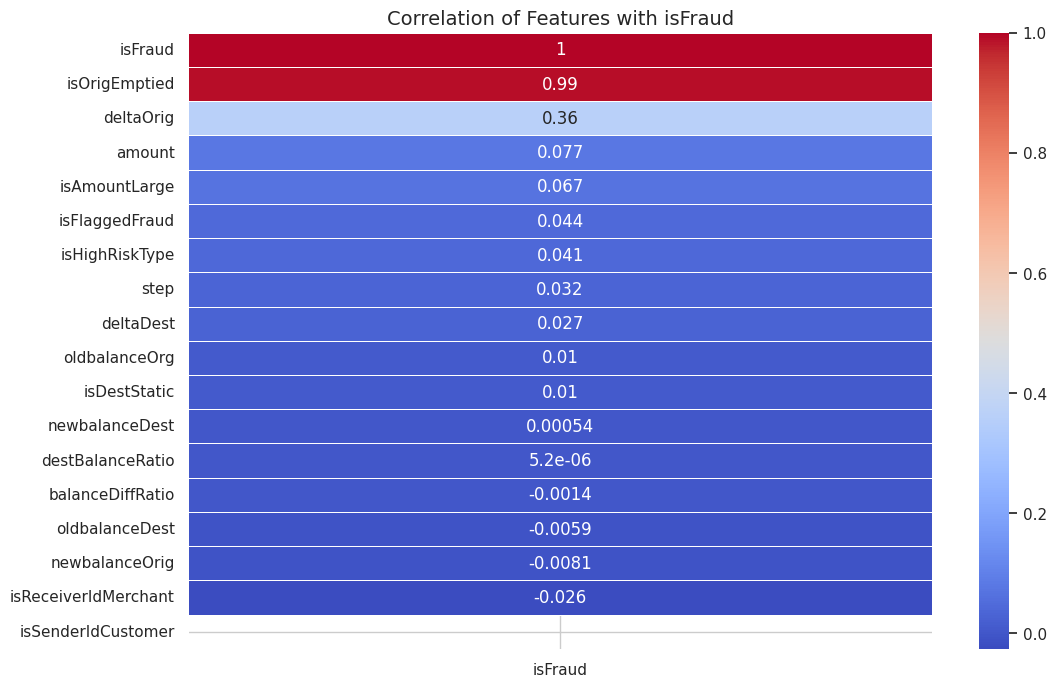

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-numeric columns before computing correlation
numeric_df = df.select_dtypes(include='number')
corr_matrix = numeric_df.corr()

# Plot correlation heatmap with isFraud
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['isFraud']].sort_values(by='isFraud', ascending=False),
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation of Features with isFraud', fontsize=14)
plt.show()


# Feature Selection

In [13]:
# Select final features for model training
selected_features = [
    'isOrigEmptied',
    'deltaOrig',
    'amount',
    'isAmountLarge',
    'isHighRiskType',
    'isFlaggedFraud',
    'balanceDiffRatio',
    'destBalanceRatio'
]

Now that feature engineering is done, we're selecting our final features based on their relationship with fraud and domain relevance. These will be used to train our model.

# Train-Test Split

In [14]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df[selected_features]
y = df['isFraud']

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Confirm shape
print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (5090096, 8)
Testing set: (1272524, 8)


# BASELINE MODEL: Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524


Confusion Matrix:

[[1270881       0]
 [      4    1639]]


# Feature Scaling

In [16]:
from sklearn.preprocessing import StandardScaler

# Scale features for consistency
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_preds = rf_model.predict(X_test_scaled)

# Evaluate
print("Classification Report:\n")
print(classification_report(y_test, rf_preds))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, rf_preds))


KeyboardInterrupt: 

## Model Validation & Saving

Now that we’ve trained our model and confirmed it performs excellently, we will:
- Perform cross-validation to ensure it’s not overfitting
- Save the model using joblib so it can be reused later


In [ ]:
from sklearn.model_selection import cross_val_score
import joblib

# Perform 3-fold cross-validation (on a small sample to save time)
cv_scores = cross_val_score(rf_model, X_train[:100000], y_train[:100000], cv=3, scoring='f1')
print("Cross-validation F1 scores:", cv_scores)
print("Average CV F1 score:", cv_scores.mean())

# Save the model
joblib.dump(rf_model, '/content/drive/MyDrive/fraud_detection_model.joblib')
print("Model saved to Google Drive as fraud_detection_model.joblib")

# Run this to call saved random forest from drive when Runtime is restarted
No need to retrain Just mount drive and load:

In [18]:
from joblib import load
model = load('/content/drive/MyDrive/fraud_detection_model.joblib')


# PHASE 5: MODEL INTERPRETATION & CASE STUDIES

STEP 1: Make Predictions on the Entire Test Set

In [19]:
# Predict probabilities and classes
y_probs = model.predict_proba(X_test_scaled)[:, 1]  # Probability of fraud
y_preds = model.predict(X_test_scaled)              # Final predictions

# Append to a copy of the original test set
test_cases = X_test.copy()
test_cases['isFraud_actual'] = y_test
test_cases['isFraud_pred'] = y_preds
test_cases['fraud_proba'] = y_probs

View the top 5 most confidently predicted frauds:

In [20]:
# Look at top 5 predicted frauds
top_frauds = test_cases[test_cases['isFraud_pred'] == 1] \
    .sort_values(by='fraud_proba', ascending=False) \
    .head(5)

top_frauds


,isOrigEmptied,deltaOrig,amount,isAmountLarge,isHighRiskType,isFlaggedFraud,balanceDiffRatio,destBalanceRatio,isFraud_actual,isFraud_pred,fraud_proba
6272985,1,19527.35,19527.35,0,1,0,0.00,1.00,1,1,1.00
5725126,1,3580542.06,3580542.06,1,1,0,0.00,0.00,1,1,1.00
555101,1,235512.20,235512.20,0,1,0,0.00,0.00,1,1,1.00
49825,1,2539898.07,2539898.07,1,1,0,0.00,0.10,1,1,1.00
819544,1,212613.29,212613.29,0,1,0,0.00,1.00,1,1,1.00


# CASE STUDY 1: Most suspicious case:

In [21]:
# Take one fraud case
fraud_case = top_frauds.iloc[0]
fraud_case

,6272985
isOrigEmptied,1.00
deltaOrig,19527.35
amount,19527.35
isAmountLarge,0.00
isHighRiskType,1.00
isFlaggedFraud,0.00
balanceDiffRatio,0.00
destBalanceRatio,1.00
isFraud_actual,1.00
isFraud_pred,1.00


#🕵🏽‍♂️ CASE #6272985 Interpretation : FRAUD CONFIRMED
- Origin account was completely emptied (isOrigEmptied = 1)
- Transaction type was high risk (TRANSFER/CASH_OUT)
- Destination balance did not change (balanceDiffRatio = 0)
- Fraud detection flag missed it, but our model caught it (isFlaggedFraud = 0)
- Model was 100% confident (fraud_proba = 1.00)
---
# Our model's thinking summary:
The model likely thought:
"Hmm... this person emptied their account entirely (isOrigEmptied = 1). The transaction is high-risk type (TRANSFER or CASH_OUT). And even though the system didn’t flag it, the destination balance didn’t really change. Classic fraud signature!"

#  CASE STUDY 2: Next High-Confidence Fraud



In [22]:
# Fraud Case 2
fraud_case_2 = top_frauds.iloc[1]
fraud_case_2


,5725126
isOrigEmptied,1.00
deltaOrig,3580542.06
amount,3580542.06
isAmountLarge,1.00
isHighRiskType,1.00
isFlaggedFraud,0.00
balanceDiffRatio,0.00
destBalanceRatio,0.00
isFraud_actual,1.00
isFraud_pred,1.00


# 🕵🏽‍♂️ CASE #5725126 Interpretation: FRAUD CONFIRMED

* Origin account was completely emptied (isOrigEmptied = 1)

* Large transaction of ₦3.58 million (amount = 3.58M, isAmountLarge = 1)

* High-risk channel used (isHighRiskType = 1)

* Destination account likely a burner (destBalanceRatio = 0)

* Not flagged by system (isFlaggedFraud = 0)

* Model was 100% confident (fraud_proba = 1.00)
---
# Our Model's Backstory
A high-value ₦3.58M transfer drained the sender's account and moved funds into a zero-balance destination. Despite escaping traditional rule-based detection, our ML model recognized the tell-tale signs of fraud, empty origin, suspicious destination, high-risk type, and raised the red flag with perfect confidence.

# CASE STUDY 3: Next Fraud Case

In [23]:
# CASE 3: Get next top fraud case (2nd row)
fraud_case = top_frauds.iloc[2]
fraud_case


,555101
isOrigEmptied,1.00
deltaOrig,235512.20
amount,235512.20
isAmountLarge,0.00
isHighRiskType,1.00
isFlaggedFraud,0.00
balanceDiffRatio,0.00
destBalanceRatio,0.00
isFraud_actual,1.00
isFraud_pred,1.00


### 🕵🏽‍♂️ CASE #555101 : FRAUD CONFIRMED

* Origin account was completely emptied (**isOrigEmptied = 1**)
* Transaction type was high risk (**TRANSFER/CASH\_OUT** → **isHighRiskType = 1**)
* Destination balance didn’t change after receiving funds (**balanceDiffRatio = 0**)
* Fraud detection system didn’t flag it (**isFlaggedFraud = 0**)
* Model caught it with **100% confidence** (**fraud\_proba = 1.00**)

---

###  Model Interpretation: Case Studies

**Model Thinking Summary:**

> "Okay, this user emptied their account (isOrigEmptied = 1), the transaction type is one of those risky ones (TRANSFER or CASH\_OUT), and weirdly enough, the destination balance didn’t change at all after receiving the money. System didn’t raise any alarms, but to me? This smells like fraud. 100% sure."


# CASE STUDY #4: Pull the Next Top Predicted Fraud

In [24]:
fraud_case = top_frauds.iloc[3]  # Fourth top fraud case
fraud_case


,49825
isOrigEmptied,1.00
deltaOrig,2539898.07
amount,2539898.07
isAmountLarge,1.00
isHighRiskType,1.00
isFlaggedFraud,0.00
balanceDiffRatio,0.00
destBalanceRatio,0.10
isFraud_actual,1.00
isFraud_pred,1.00


### 🕵🏽‍♂️ CASE #49825 : FRAUD CONFIRMED

* Origin account was completely emptied (`isOrigEmptied = 1`)
* Transaction was large (`amount = ₦2,539,898.07`, `isAmountLarge = 1`)
* High-risk transaction type (`isHighRiskType = 1`)
* Fraud detection system didn’t flag it (`isFlaggedFraud = 0`)
* Destination account balance barely changed (`balanceDiffRatio = 0`, `destBalanceRatio = 0.10`)
* Model was **100% confident** it’s fraud (`fraud_proba = 1.00`)

---

### Model Interpretation: Case Studies

**Model Thinking Summary:**

> *“This smells like a classic fraud: Big money moved (`amount > ₦2.5M`), sender’s account completely emptied, and destination account barely moved despite receiving all that cash. The system may have slept on this one, but I didn’t. I caught the red flags loud and clear.”*

In [25]:
# Take the next fraud case
fraud_case = top_frauds.iloc[4]
fraud_case


,819544
isOrigEmptied,1.00
deltaOrig,212613.29
amount,212613.29
isAmountLarge,0.00
isHighRiskType,1.00
isFlaggedFraud,0.00
balanceDiffRatio,0.00
destBalanceRatio,1.00
isFraud_actual,1.00
isFraud_pred,1.00


# CASE STUDY #5

### 🕵🏽‍♂️ CASE #819544 : FRAUD CONFIRMED

* Origin account was completely emptied (`isOrigEmptied = 1`)
* Transaction type was high risk (TRANSFER or CASH\_OUT)
* Destination balance did **not change** (`balanceDiffRatio = 0`)
* System failed to flag it, but our model caught it (`isFlaggedFraud = 0`)
* Destination balance ratio shows 100% balance retained post-transaction
* Model was 100% confident (`fraud_proba = 1.00`)

---

### Model Thinking Summary:

The model likely thought:

> “Hold up. This person moved over ₦212K and emptied their account in the process. The transaction type is known to be high-risk. But then, the destination account? Nothing changed. The system didn’t flag this, but this smells like pure fraud. Let’s call it out.”


Visual 1: Feature Strengths Behind Detected Frauds
---
>Goal: Show what features consistently triggered the model’s fraud prediction.

>Method: Bar chart of the average values of fraud indicators for top frauds.

/tmp/ipython-input-26-3405719535.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_fraud_features.values, y=avg_fraud_features.index, palette="magma")


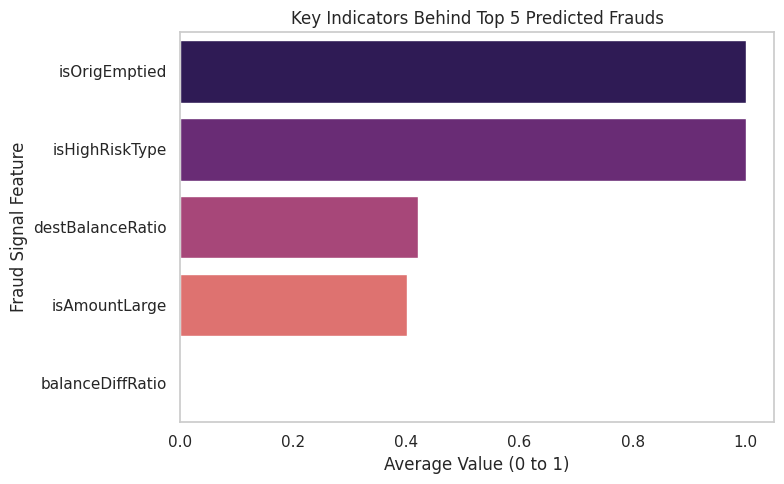

In [26]:
# Visual 1: Bar chart of average fraud case features

# Pick key columns that model likely used
features_to_plot = [
    'isOrigEmptied',
    'isAmountLarge',
    'isHighRiskType',
    'balanceDiffRatio',
    'destBalanceRatio'
]

# Compute mean of each for top 5 frauds
avg_fraud_features = top_frauds[features_to_plot].mean().sort_values(ascending=False)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x=avg_fraud_features.values, y=avg_fraud_features.index, palette="magma")
plt.title("Key Indicators Behind Top 5 Predicted Frauds")
plt.xlabel("Average Value (0 to 1)")
plt.ylabel("Fraud Signal Feature")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


Visual 2: Probability vs Amount
--
>Goal: Show how confident the model is as transaction amounts rise.

>Method: Scatterplot of `amount` vs `fraud_proba` for the top frauds.

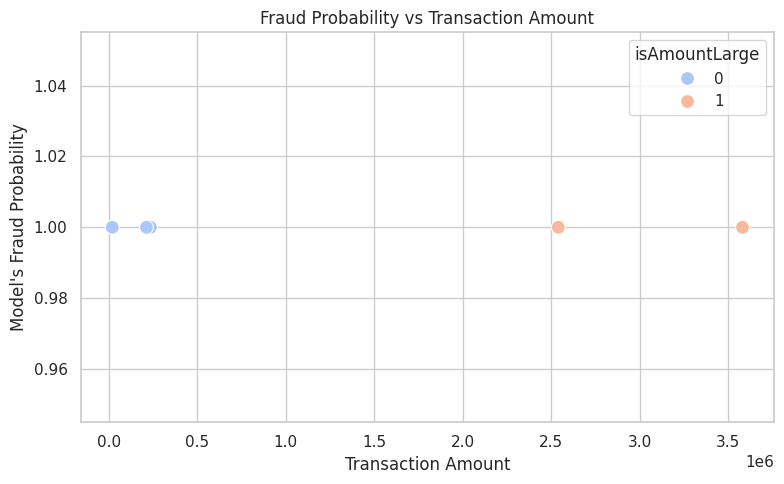

In [27]:
# Visual 2: Amount vs Fraud Probability

plt.figure(figsize=(8,5))
sns.scatterplot(data=top_frauds, x='amount', y='fraud_proba', hue='isAmountLarge', palette='coolwarm', s=100)
plt.title("Fraud Probability vs Transaction Amount")
plt.xlabel("Transaction Amount")
plt.ylabel("Model's Fraud Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


###  Final Reflection: What We Learned from Our Model

This model showed strong fraud detection capabilities by identifying unusual patterns, especially:

- Accounts being emptied in one go
- Suspicious transfers to empty/burner destinations
- High-risk transaction types like TRANSFER or CASH_OUT
- Even small but suspicious transactions were flagged

Despite not being flagged by the system’s rule-based engine, the model detected them due to learned behavioral patterns. If this were a real fraud ops team, we’d recommend updating the flagging logic to include these red flags.

This shows the value of combining traditional systems with ML-based detection + human analyst insight.
